<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/Ch03_%EB%B6%84%EB%A5%98_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Ch 03. 분류**

가장 일반적인 지도 학습 작업인 회귀와 분류.

##3.1 MNIST
고등학생과 미국 인구조사국 직원들이 손으로 쓴 70,000개의 작은 숫자 이미지 MNIST 데이터셋. 사이킷런의 헬퍼 함수를 사용해 내려받을 수 있다.

In [1]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784', version=1)
mnist.keys()

/usr/local/lib/python3.8/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 갖는다.
* 데이터셋을 설명하는 DESCR 키
* 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
* 레이블 배열을 담은 target 키

In [2]:
X, y=mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

70,000개 이미지와 각 이미지의 784개(28*28 픽셀)의 특성. 각 특성은 0부터 255까지의 픽셀 강도(흰백)를 나타낸다. 데이터셋에서 이미지 하나를 확인해보자.

In [4]:
X.reset_index(inplace = True,drop = True)

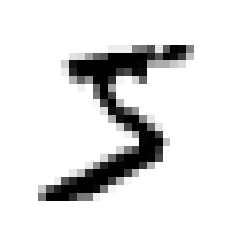

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit=X[:1]
some_digit_image=np.array(some_digit).reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [6]:
y[0]

'5'

책을 보니 그림이 5로 보이고, 레이블을 확인한 결과 5가 맞다.

대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환하자.

In [7]:
import numpy as np
y=y.astype(np.uint8)

데이터를 자세히 조사하기 전, 항상 테스트 데이터 세트를 만들고 따로 떼어놓아야한다. MNIST 데이터는 이미 훈련 세트(앞쪽 60,000개)와 테스트 세트(뒤쪽 10,000개) 나누어 놓았다.

In [8]:
X_train, X_test, y_train, y_test=X[:60000], X[60000:], y[:60000], y[60000:]

훈련 세트는 이미 섞여 있어서 모든 교차 검증 폴드를 비슷하게 만든다. 데이터셋을 섞으면 비슷한 샘플이 연이어 나타나 성능이 나빠지는 문제를 방지 할 수 있다.

##3.2 이진 분류기 훈련

하나의 숫자(5)만 식별해보자. 이 분류는 '5'와 '5 아님' 두 개의 클래스를 구분할 수 있는 **이진 분류기**.

In [9]:
y_train_5=(y_train==5) #5는 true고, 다른 숫자는 모두 false
y_test_5=(y_test==5)

분류 모델을 선택해서 훈련해보자. 사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법 분류기로 시작해보자. 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문에 매우 큰 데이터셋의 효율적 처리 가능.

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf=SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
# 이 모델을 사용해 숫자 5의 이미지를 감지해보자
sgd_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


ValueError: ignored

##3.3 성능 측정

###3.3.1 **교차 검증**을 사용한 정확도 측정

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf=clone(sgd_clf)
  X_train_folds=X_train[train_index]
  y_train_folds=y_train_5[train_index]
  X_test_fold=X_train[test_index]
  y_test_fold=y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred=clone_clf.predict(X_test_fold)
  n_correct=sum(y_pred==y_test_fold)
  print(n_correct/len(y_pred)) # 0.9502, 0.96565, 0.96495 출력됨

KeyError: ignored

StratifiedKFold는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행한다.

cross_val_score() 함수로 폴드가 3개인 교차 검증을 사용해 평가해보자.

In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

모든 폴드에 대해 정확도가 0.9 이상!

모든 이미지를 '5 아님'클래스로 분류하는 더미 분류기를 만들어 비교해보자.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

역시 정확도가 모두 0.9 이상! 하지만 정확도는 불균형한 데이터셋을 다룰 때 분류기의 성능 측정 지표로 선호하지 않는다.

###3.3.2 오차 행렬

기본적인 아이디어는 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것. 오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다.

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_score 함수처럼 cross_val_predict 함수는 교차 검증을 수행하지만 평가 점수를 반환하지 않고 각 테스트 폴드에서 얻은 **예측**을 반환.

이제 오차 행렬을 만들어보자.

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

행 : 실제 클래스
<br/>열 : 예측한 클래스

그래서 이 행렬의 첫 행은 '5 아님'에 대한 것으로 53892개를 5 아님으로 정확히 분류. 3530개를 5로 정확히 분류.

In [18]:
y_train_perfect_predictions=y_train_5 #완벽한 분류기의 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

오차 행렬이 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요. 양성 예측의 정확도인 정밀도와 재현율(=민감도, 진짜 양성 비율).

###3.3.3 정밀도와 재현율

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530/(3530+687)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_pred) # == 3530/(3530+1891)

0.6511713705958311

'5-감지기'가 정확도에서 봤을 때만큼 정확해 보이지는 않는다. **5로 판별된 이미지 중 83.7%만 정확, 전체 숫자 5에서 65.1%만 감지**.

정밀도와 재현율을 F1 점수(=정밀도와 재현율의 조화 평균)로 만들면 편리하다.

In [21]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다. 하지만 상황에 따라 무조건 좋은 것은 아님. 또한 정밀도/재현율 트레이드오프가 있음을 기억하자.

###3.3.4 정밀도/재현율 트레이드오프

SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 이 트레이드오프를 이해해보자. 이 분류기는 결정 함수를 사용하여 각 샘플의 점수를 계산한다. 이 점수가 임계값보다 크면 양성 아니면 음성 클래스에 할당. 임계값 높이면 정밀도 높아지고 재현율이 줄어든다. 반대의 경우는 정밀도가 낮아지고 재현율이 높아진다.

사이킷런에서 임계값을 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다.

In [22]:
y_scores=sgd_clf.decision_function([some_digit])
y_scores

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


ValueError: ignored

In [23]:
threshold=0
y_some_digit_pred=(y_scores>threshold) #True 반환

NameError: ignored

In [24]:
threshold=8000
y_some_digit_pred=(y_scores>threshold)
y_some_digit_pred #False 반환

NameError: ignored

역시 임계값을 높이면 재현율이 줄어든다. 

적절한 임계값을 어떻게 정하지? 예측 결과 아니라 결정 점수를 반환하도록 지정하여 모든 샘플의 점수를 구하자.

In [25]:
y_scores=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

이 점수로 precision_recall_curve() 함수를 사용해 가능한 모든 임계값에 대한 정밀도와 재현율을 계산 가능.

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.8/dist-packages/IPy

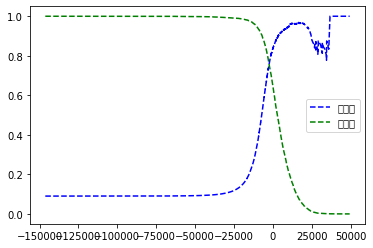

In [27]:
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='정밀도')
  plt.plot(thresholds, recalls[:-1], 'g--', label='재현율')
  plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

다른 방법은 재현율에 대한 정밀도 곡선을 그리는 것이 있다.

재현율 80% 근처에서 정밀도가 급격히 감소하기 시작한다. 이 지점을 트레이드오프로 선택하자!

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.019499143958

아니면 이렇게 정밀도 90%를 달성하는 것이 목적인 경우, 임계값을 찾을 수 있다.

훈련 세트에 대한 예측을 만들려면 분류기의 predict() 메서드를 호출하는 대신 다음 코드 실행

In [29]:
y_train_pred_90=(y_scores >= threshold_90_precision)

In [30]:
#이 예측에 대한 정밀도와 재현율을 확인하자
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

굿. 하지만 재현율이 너무 낮다면 높은 정밀도의 분류기는 전혀 쓸모가 없다.

###3.3.5 ROC 곡선

정밀도/재현율 곡선과 매우 비슷하지만 **거짓 양성 비율에 대한 진짜 양성 비율의 곡선**. **= 민감도(재현율)에 대한 1-특이도** 그래프.

TPR과 FPR을 먼저 계산해야한다.

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

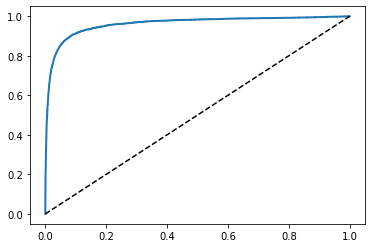

In [33]:
# 곡선도 나타내보자
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') #대각 점선
  
plot_roc_curve(fpr, tpr)
plt.show()

여기도 트레이드오프 있다. 재현율(TPR) 높을수록 FPR이 늘어난다. 좋은 분류는 대각 점선에서 최대한 멀리 떨어져있다.

곡선 아래의 면적 AUC를 측정하여 비교한다.

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

* ROC 곡선과 정밀도/재현율 곡선 중 어떤 것을 사용할까? 일반적으로는 양성 클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 정밀도/재현율 곡선을 사용, 아니면 ROC 곡선을 사용.

랜덤포레스트분류를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교해보자.

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

roc_curv 함수는 레이블과 점수를 기대하지만 점수 대신 클래스 확률을 전달 할 수 있다. 양성 클래스 확률을 점수로 사용해보자.

In [36]:
y_scores_forest=y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

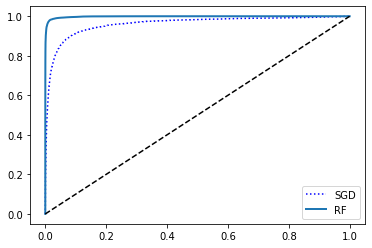

In [37]:
#이제 ROC 그려보자. 비교를 위해 첫번째 ROC도 그리자.
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'RF')
plt.legend(loc='lower right')
plt.show()

RF의 ROC 곡선이 훨씬 좋아보인다. 

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

나쁘지 않다.

##3.4 다중 분류

SGD, 랜덤 포레스트, 나이브 베이즈 같은 분류기는 여러 개의 클래스를 직접 처리할 수 있지만, 로지스틱 회귀나 서포트 벡터 머신 분류기 등은 이진 분류만 가능. 하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하기도 한다.

OvR(=OvA)는 이미지를 분류할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택하면 된다. 다른 전략 OvO는 각 숫자의 조합마다 이진 분류를 훈련시키는 것이다. 모든 분류기를 통과시켜 가장 많이 양성으로 분류된 클래스를 선택한다.

다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행한다.

In [39]:
from sklearn.svm import SVC
svm_clf=SVC()
svm_clf.fit(X_train, y_train) # 이제 y_train_5가 아님
svm_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


ValueError: ignored

이 코드는 5를 구별한 타깃 클래스 대신 원래 타깃 클래스를 사용해 훈련시킨다. 그 다음 예측 하나를 만든다. 내부에 사이킷런이 OvO 전략을 사용해 10개의 이진 분류기를 훈련시키고 각각의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택한다.

확인해보자. decision_function() 메서드를 호출하면 샘플당 10개의 점수를 반환한다. 이 점수는 클래스마다 하나씩이다.

In [40]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


ValueError: ignored

가장 높은 점수가 클래스 5에 해당하는 값.

In [41]:
np.argmax(some_digit_scores) #5출력

NameError: ignored

In [43]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [44]:
svm_clf.classes_[5]

5

사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier 사용

In [45]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf=OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


ValueError: ignored

In [46]:
len(ovr_clf.estimators_)

10

In [47]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


ValueError: ignored

이 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 사이킷런의 OvR, OvO를 적용할 필요가 없다. SGD 분류기가 클래스마다 부여한 점수를 확인해보자.

In [48]:
sgd_clf.decision_function([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


ValueError: ignored

대부분의 점수가 큰 음수인 반면 클래스 5의 점수가 매우 크다.

분류기를 평가해보자. 일반적으로 교차 검증 사용.

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

모든 폴드에서 84% 이상이다. 나쁘진 않지만 성능을 높일 여지가 있다. 간단하게 입력의 스케일을 조절하자.

In [50]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

##3.5 에러 분석

좋은 모델을 하나 찾았다고 가정하고 이 모델의 성능을 향상해보자. 한 가지 방법은 에러의 종류를 분석하는 것.

먼저 오차 행렬을 살펴보자.

In [51]:
y_train_pred=cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx=confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

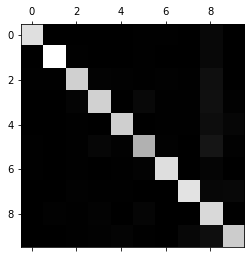

In [52]:
#이미지로 표현하자
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

이 오차 행렬은 대부분의 이미지가 올바르게 분류되었음을 나타내는 주대각선에 있으므로 매우 좋아보인다. 숫자 5가 좀 어두운데, 이는 데이터셋에 5의 이미지가 적거나 분류기가 5를 다른 숫자만큼 잘 분류하지 못한다는 뜻. 두 경우 모두 확인해야 한다.

그래프의 에러 부분에 초점을 맞추자. 에러 비율을 비교해보자.

In [53]:
row_sums=conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx=conf_mx/row_sums

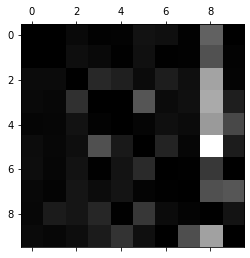

In [54]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

분류기가 만든 에러가 확실히 보인다. 클래스의 8열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류된 듯 하다. 하지만 행은 나쁘지 않음. -> 실제 8은 적절히 8로 분류됨. 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있어보인다.

3, 5의 샘플을 그려보자.

In [55]:
import matplotlib

def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

AttributeError: ignored

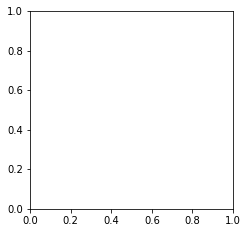

In [57]:
cl_a, cl_b=3,5
X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

대부분의 잘못 분류된 이미지는 확실히 에러인 것 같고, 이유를 알기 어렵다. 원인은 SGDClassifier를 사용했기 때문이다. 이미지의 위치나 회전 방향에 대한 분류기의 민감도 때문. 이 에러를 줄이는 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리하는 것.

##3.6 다중 레이블 분류

지금까지 각 샘플이 하나의 클래스에만 할당됨. 하지만 샘플마다 여러 개의 클래스를 출력해야하면?

간단한 예를 살펴보자.

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large=(y_train>=7)
y_train_odd=(y_train%2==1)
y_multilabel=np.c_[y_train_large, y_train_odd]

knn_clf=KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

이 코드는 각 숫자 이미지에 두 개의 타깃 레이블이 담긴 y_multilabel 배열을 만든다. 이제 예측을 만들면 레이블이 두 개 출력된다.

In [59]:
knn_clf.predict([some_digit])

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


ValueError: ignored

올바르게 분류됨.

다중 레이블 분류를 평가하는 방법은 많다.

In [60]:
#예를 들어 F1 점수를 구해보자
y_train_knn_pred=cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

모든 레이블의 가중치가 같다고 가정한 것. 가중치를 줘야 할 경우 레이블에 클래스의 지지도를 가중치로 주는 것.

##3.7 다중 출력 분류

이미지에서 잡음을 제거하는 시스템을 만들어보자. 분류기의 출력이 다중 레이블(픽셀당 한 레이블)이고 각 레이블은 값을 여러개 가진다. 그러므로 이 예는 다중 출력 분류 시스템.

In [61]:
#MNIST에 잡음 추가
noise=np.random.randint(0,100,(len(X_train), 784))
X_train_mod=X_train+noise
noise=np.random.randint(0,100,(len(X_test), 784))
X_test_mod=X_test+noise
y_train_mod=X_train
y_test_mod=X_test

분류기를 훈련시켜 이미지를 깨끗하게 만들어보자.

In [62]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit=knn_clf.predict([X_test_mod[30]])
plot_digits(clean_digit)

KeyError: ignored

타깃과 매우 비슷하다.